<a href="https://colab.research.google.com/github/JSJeong-me/RNX/blob/main/AHE/ahe-0129.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from skimage import exposure, util
import imageio as io

In [2]:
# Prepare data and apply histogram equalization

from skimage.data import cells3d

im_orig = util.img_as_float(cells3d()[:, 1, :, :])  # grab just the nuclei

In [3]:
im_orig.shape

(60, 256, 256)

In [4]:
# Reorder axis order from (z, y, x) to (x, y, z)
im_orig = im_orig.transpose()

# Rescale image data to range [0, 1]
im_orig = np.clip(im_orig,
                  np.percentile(im_orig, 5),
                  np.percentile(im_orig, 95))
im_orig = (im_orig - im_orig.min()) / (im_orig.max() - im_orig.min())

# Degrade image by applying exponential intensity decay along x
sigmoid = np.exp(-3 * np.linspace(0, 1, im_orig.shape[0]))
im_degraded = (im_orig.T * sigmoid).T

In [5]:
# Set parameters for AHE
# Determine kernel sizes in each dim relative to image shape
kernel_size = (im_orig.shape[0] // 5,
               im_orig.shape[1] // 5,
               im_orig.shape[2] // 2)
kernel_size = np.array(kernel_size)
clip_limit = 0.9

In [6]:
# Perform histogram equalization
im_orig_he, im_degraded_he = \
    [exposure.equalize_hist(im)
     for im in [im_orig, im_degraded]]

im_orig_ahe, im_degraded_ahe = \
    [exposure.equalize_adapthist(im,
                                 kernel_size=kernel_size,
                                 clip_limit=clip_limit)
     for im in [im_orig, im_degraded]]


In [7]:
# Define functions to help plot the data

def scalars_to_rgba(scalars, cmap, vmin=0., vmax=1., alpha=0.2):
    """
    Convert array of scalars into array of corresponding RGBA values.
    """
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    rgbas = scalar_map.to_rgba(scalars)
    rgbas[:, 3] = alpha
    return rgbas


def plt_render_volume(vol, fig_ax, cmap,
                      vmin=0, vmax=1,
                      bin_widths=None, n_levels=20):
    """
    Render a volume in a 3D matplotlib scatter plot.
    Better would be to use napari.
    """
    vol = np.clip(vol, vmin, vmax)

    xs, ys, zs = np.mgrid[0:vol.shape[0]:bin_widths[0],
                          0:vol.shape[1]:bin_widths[1],
                          0:vol.shape[2]:bin_widths[2]]
    vol_scaled = vol[::bin_widths[0],
                     ::bin_widths[1],
                     ::bin_widths[2]].flatten()

    # Define alpha transfer function
    levels = np.linspace(vmin, vmax, n_levels)
    alphas = np.linspace(0, .7, n_levels)
    alphas = alphas ** 11
    alphas = (alphas - alphas.min()) / (alphas.max() - alphas.min())
    alphas *= 0.8

    # Group pixels by intensity and plot separately,
    # as 3D scatter does not accept arrays of alpha values
    for il in range(1, len(levels)):
        sel = (vol_scaled >= levels[il - 1])
        sel *= (vol_scaled <= levels[il])
        if not np.max(sel):
            continue
        c = scalars_to_rgba(vol_scaled[sel], cmap,
                            vmin=vmin, vmax=vmax, alpha=alphas[il - 1])
        fig_ax.scatter(xs.flatten()[sel],
                       ys.flatten()[sel],
                       zs.flatten()[sel],
                       c=c, s=0.5 * np.mean(bin_widths),
                       marker='o', linewidth=0)


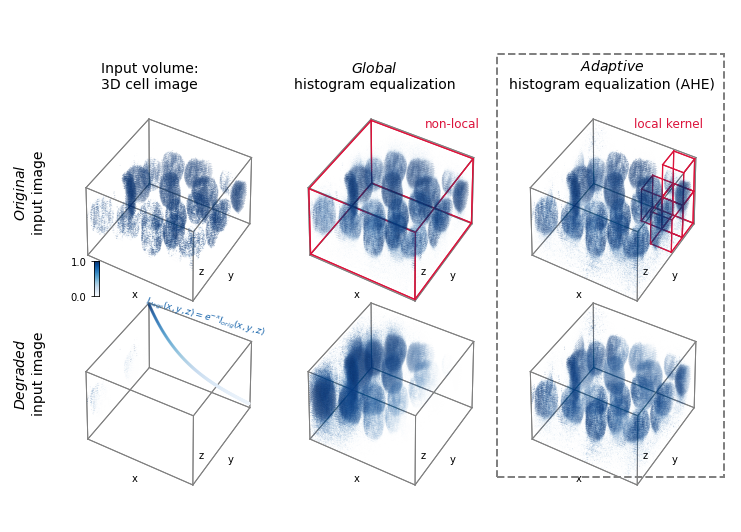

In [8]:


# Create figure with subplots

cmap = 'Blues'

fig = plt.figure(figsize=(10, 6))
axs = [fig.add_subplot(2, 3, i + 1,
                       projection=Axes3D.name, facecolor="none")
       for i in range(6)]
ims = [im_orig, im_orig_he, im_orig_ahe,
       im_degraded, im_degraded_he, im_degraded_ahe]

# Prepare lines for the various boxes to be plotted
verts = np.array([[i, j, k] for i in [0, 1]
                  for j in [0, 1] for k in [0, 1]]).astype(np.float32)
lines = [np.array([i, j]) for i in verts
         for j in verts if np.allclose(np.linalg.norm(i - j), 1)]

# "render" volumetric data
for iax, ax in enumerate(axs[:]):
    plt_render_volume(ims[iax], ax, cmap, 0, 1, [2, 2, 2], 20)

    # plot 3D box
    rect_shape = np.array(im_orig.shape) + 2
    for line in lines:
        ax.plot((line * rect_shape)[:, 0] - 1,
                (line * rect_shape)[:, 1] - 1,
                (line * rect_shape)[:, 2] - 1,
                linewidth=1, color='gray')

# Add boxes illustrating the kernels
ns = np.array(im_orig.shape) // kernel_size - 1
for axis_ind, vertex_ind, box_shape in zip([1] + [2] * 4,
                                [[0, 0, 0],
                                 [ns[0] - 1, ns[1], ns[2] - 1],
                                 [ns[0], ns[1] - 1, ns[2] - 1],
                                 [ns[0], ns[1], ns[2] - 1],
                                 [ns[0], ns[1], ns[2]]],
                                [np.array(im_orig.shape)]
                                + [kernel_size] * 4):

    for line in lines:
        axs[axis_ind].plot(((line + vertex_ind) * box_shape)[:, 0],
                           ((line + vertex_ind) * box_shape)[:, 1],
                           ((line + vertex_ind) * box_shape)[:, 2],
                           linewidth=1.2, color='crimson')

# Plot degradation function
axs[3].scatter(xs=np.arange(len(sigmoid)),
               ys=np.zeros(len(sigmoid)) + im_orig.shape[1],
               zs=sigmoid * im_orig.shape[2],
               s=5,
               c=scalars_to_rgba(sigmoid,
                                 cmap=cmap, vmin=0, vmax=1, alpha=1.)[:, :3])

# Subplot aesthetics (optimized for matplotlib 3.3)
for iax, ax in enumerate(axs[:]):

    # Get rid of panes and axis lines
    for dim_ax in [ax.xaxis, ax.yaxis, ax.zaxis]:
        dim_ax.set_pane_color((1., 1., 1., 0.))
        dim_ax.line.set_color((1., 1., 1., 0.))

    # Define 3D axes limits, see https://github.com/
    # matplotlib/matplotlib/issues/17172#issuecomment-617546105
    xyzlim = np.array([ax.get_xlim3d(),
                       ax.get_ylim3d(),
                       ax.get_zlim3d()]).T
    XYZlim = np.asarray([min(xyzlim[0]), max(xyzlim[1])])
    ax.set_xlim3d(XYZlim)
    ax.set_ylim3d(XYZlim)
    ax.set_zlim3d(XYZlim * 0.5)

    try:
        ax.set_aspect('equal')
    except NotImplementedError:
        pass

    ax.set_xlabel('x', labelpad=-20)
    ax.set_ylabel('y', labelpad=-20)
    ax.text2D(0.63, 0.2, "z", transform=ax.transAxes)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.grid(False)
    ax.elev = 30

plt.subplots_adjust(left=0.05,
                    bottom=-0.1,
                    right=1.01,
                    top=1.1,
                    wspace=-0.1,
                    hspace=-0.45)

# Highlight AHE
rect_ax = fig.add_axes([0, 0, 1, 1], facecolor='none')
rect_ax.set_axis_off()
rect = patches.Rectangle((0.68, 0.01), 0.315, 0.98,
                         edgecolor='gray', facecolor='none',
                         linewidth=2, linestyle='--')
rect_ax.add_patch(rect)

# Add text
rect_ax.text(0.19, 0.34, '$I_{degr}(x,y,z) = e^{-x}I_{orig}(x,y,z)$',
             fontsize=9, rotation=-15,
             color=scalars_to_rgba([0.8], cmap='Blues', alpha=1.)[0])

fc = {'size': 14}
rect_ax.text(0.03, 0.58, r'$\it{Original}$' + '\ninput image',
             rotation=90, fontdict=fc, horizontalalignment='center')
rect_ax.text(0.03, 0.16, r'$\it{Degraded}$' + '\ninput image',
             rotation=90, fontdict=fc, horizontalalignment='center')
rect_ax.text(0.13, 0.91, 'Input volume:\n3D cell image', fontdict=fc)
rect_ax.text(0.51, 0.91, r'$\it{Global}$' + '\nhistogram equalization',
             fontdict=fc, horizontalalignment='center')
rect_ax.text(0.84, 0.91,
             r'$\it{Adaptive}$' + '\nhistogram equalization (AHE)',
             fontdict=fc, horizontalalignment='center')
rect_ax.text(0.58, 0.82, 'non-local', fontsize=12, color='crimson')
rect_ax.text(0.87, 0.82, 'local kernel', fontsize=12, color='crimson')

# Add colorbar
cbar_ax = fig.add_axes([0.12, 0.43, 0.008, 0.08])
cbar_ax.imshow(np.arange(256).reshape(256, 1)[::-1],
               cmap=cmap, aspect="auto")
cbar_ax.set_xticks([])
cbar_ax.set_yticks([0, 255])
cbar_ax.set_xticklabels([])
cbar_ax.set_yticklabels([1., 0.])

plt.show()